# ML lab 01 - Data preprocessing

In [40]:
%load_ext autoreload

In [41]:
# Uncomment to upgrade packages
!pip3 install pandas --user --upgrade --quiet
!pip3 install numpy --user --upgrade --quiet
!pip3 install scipy --user --upgrade --quiet
!pip3 install statsmodels --user --upgrade --quiet
!pip3 install seaborn --user --upgrade --quiet
!pip3 install scikit-learn --user --upgrade --quiet

In [42]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option("display.precision", 3)

In [43]:
# extra imports
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from statsmodels.genmod.generalized_linear_model import GLM
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox

In [44]:
pd.__version__

'1.5.3'

## SECTION 1: READING THE FILE CREDSCO.TXT (loan data: credit scoring)

 Reading properly a data set is non-trivial because you need to know
 its data format: decimal separator, column separator, is there a
 header? how are strings quoted? how (if any) are missing values
 coded? should character vectors be converted to factors? should
 white spaces be stripped?, ...)

 It is a good idea to consult  [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)  and play with useful control parameters.
 
 after opening the file `credsco.csv` and inspecting it, we decide the following settings:

In [45]:
Credit = read_csv("credsco.csv", header=0, delimiter=',')
Credit.shape

(4455, 14)

 Basic questions:

* Which is the target variable? where is it? how many different values? is it a classification problem or a regression problem?

* *answers:* the target variable is located in column 1 and is called 'Assessment'; it has two possible values (therfore it is a classification problem)

What are the other variables?

In [46]:
Credit.columns

Index(['Assessment', 'YearsInJob', 'Housing', 'Deadline', 'Age',
       'MaritalStatus', 'Records', 'TypeOfJob', 'Expenses', 'Income',
       'Capital', 'ChargesOnCapital', 'AmountRequested', 'MarketPrice'],
      dtype='object')

In [47]:
Credit[:4]

,Assessment,YearsInJob,Housing,Deadline,Age,MaritalStatus,Records,TypeOfJob,Expenses,Income,Capital,ChargesOnCapital,AmountRequested,MarketPrice
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325


inspect predictive variables 4, 5, 6 and 7 for the first example

In [48]:
Credit.iloc[0,4:8]

Age              30
MaritalStatus     2
Records           1
TypeOfJob         3
Name: 0, dtype: int64

Alternatively you can use the variable names

In [49]:
Credit.loc[0,'Age':'TypeOfJob']

Age              30
MaritalStatus     2
Records           1
TypeOfJob         3
Name: 0, dtype: int64

***
## SECTION 2: BASIC INSPECTION OF THE DATASET

Perform a basic inspection of the dataset. Have a look at the minimum and maximum values for each variable; find possible errors and abnormal values (outliers); find possible missing values; decide which variables are continuous and which are categorical; if there are mixed types, we have three options: recode continuous to categorical, recode categorical to continuous or leave them as they are. In the latter case, either the method accepts both kinds of information, or it does not, in which case python will convert the categorical ones to continuous using a dummy code.

In [50]:
Credit.describe()

,Assessment,YearsInJob,Housing,Deadline,Age,MaritalStatus,Records,TypeOfJob,Expenses,Income,Capital,ChargesOnCapital,AmountRequested,MarketPrice
count,4455.000,4455.000,4455.000,4455.000,4455.000,4455.000,4455.000,4455.000,4455.000,4.455e+03,4.455e+03,4.455e+03,4455.000,4455.000
mean,1.281,7.987,2.657,46.442,37.078,1.879,1.174,1.676,55.569,7.633e+05,1.060e+06,4.044e+05,1039.022,1462.876
std,0.450,8.173,1.610,14.655,10.985,0.644,0.379,0.954,19.516,8.704e+06,1.022e+07,6.344e+06,474.543,628.090
min,0.000,0.000,0.000,6.000,18.000,0.000,1.000,0.000,35.000,0.000e+00,0.000e+00,0.000e+00,100.000,105.000
25%,1.000,2.000,2.000,36.000,28.000,2.000,1.000,1.000,35.000,8.000e+01,0.000e+00,0.000e+00,700.000,1117.500
50%,1.000,5.000,2.000,48.000,36.000,2.000,1.000,1.000,51.000,1.200e+02,3.500e+03,0.000e+00,1000.000,1400.000
75%,2.000,12.000,4.000,60.000,45.000,2.000,1.000,3.000,72.000,1.660e+02,6.000e+03,0.000e+00,1300.000,1692.000
max,2.000,48.000,6.000,72.000,68.000,5.000,2.000,4.000,180.000,1.000e+08,1.000e+08,1.000e+08,5000.000,11140.000


 `Assessment`,`Housing`,`MaritalStatus`,`Records`,`TypeOfJob` are categorical and need to be treated properly

 In particular, `Assessment` is the target variable; we need to identify correct values

 `Capital`, `ChargesOnCapital` and `Income` present abnormally high maximums (99999999)

 There are also suspicious zeros, in both types of variables, which we identify with missing values

In [51]:
Credit['Assessment'].value_counts()

1    3200
2    1254
0       1
Name: Assessment, dtype: int64

## SECTION 3: DEALING WITH MISSING VALUES

Sometimes we need to take a decision on a sensible treatment for the missing values and apply it; it is wise to write down the possible consequences of this decision and the alternatives that could be considered in case the final results are not satisfactory

the easiest way is of course to eliminate the involved rows or
columns; this can be done partially. For example, we could decide to
eliminate the variables with the highest proportion of missing values.

Deleting instances and/or variables containing missing values results
in loss of relevant data and is also frustrating because of the effort
in collecting the sacrificed information.

<div class="alert alert-block alert-warning">
CAREFUL! python does not know magically which entries are missing values: they have to be explicitly declared as NA's
</div>

therefore this code is not useful:

In [52]:
Credit_complete = Credit.dropna()
Credit_complete.shape

(4455, 14)

 the previous code does nothing! (but it seems it does)

 In the present case we have decided to perform a step-by-step treatment, separate for the categorical and continuous information

 We first decide to remove those rows with with missing values in the categorical variables (there are few)

In [53]:
(Credit.Assessment==0).value_counts()
(Credit.Housing==0).value_counts()
(Credit.MaritalStatus==0).value_counts()
(Credit.TypeOfJob==0).value_counts()

False    4454
True        1
Name: Assessment, dtype: int64

False    4449
True        6
Name: Housing, dtype: int64

False    4454
True        1
Name: MaritalStatus, dtype: int64

False    4453
True        2
Name: TypeOfJob, dtype: int64

In [54]:
Credit=  Credit[(Credit.Assessment!=0) & (Credit.Housing!=0)
                &(Credit.MaritalStatus!=0)&(Credit.TypeOfJob!=0)]
Credit.shape

(4446, 14)

 Process rows with missing values in the continuous variables (code 99999999)

 look at that:

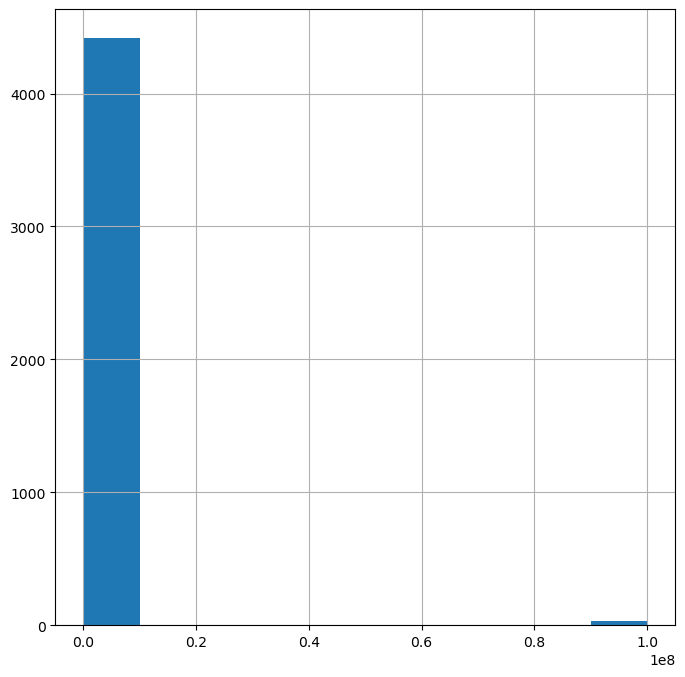

In [55]:
Credit.Income.hist(figsize=(8,8));

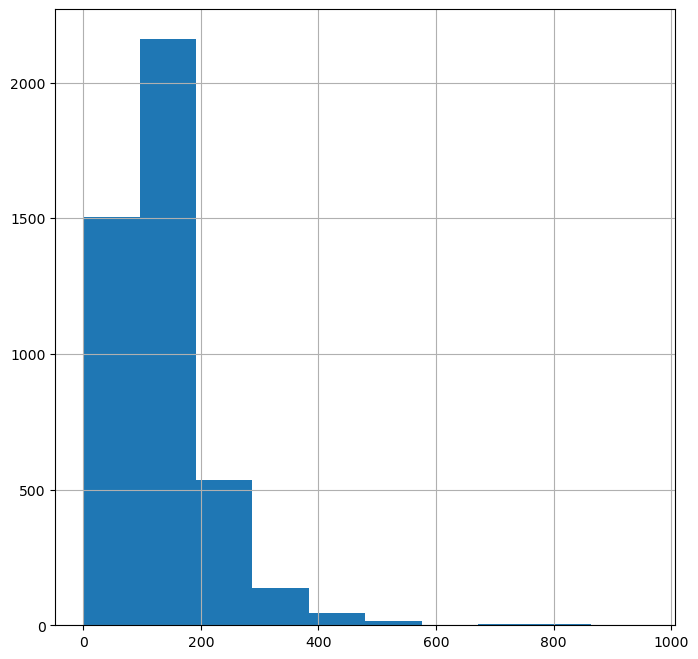

In [56]:
Credit.Income[Credit.Income!=99999999].hist(figsize=(8,8));

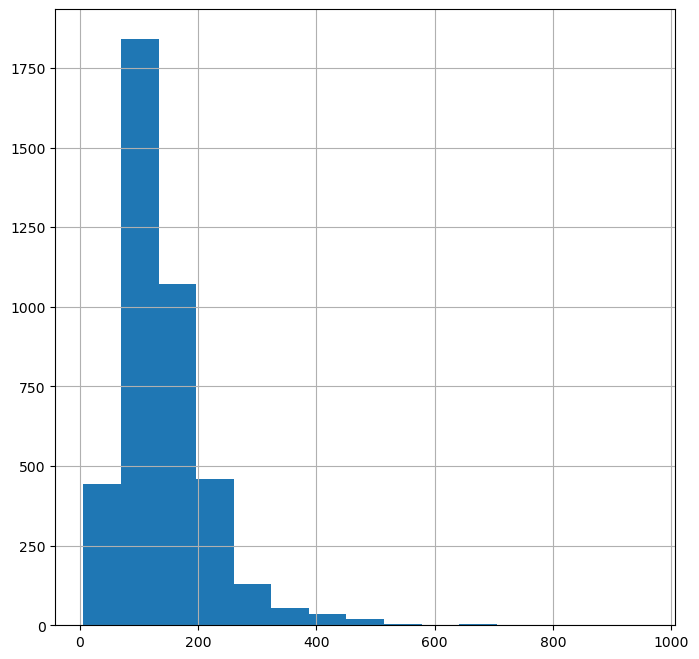

In [57]:
Credit.Income[(Credit.Income!=99999999)&
              (Credit.Income!=0)].hist(bins=15,figsize=(8,8));

 these are then clearly incorrect

In [58]:
(Credit.Income==99999999).value_counts()
(Credit.Income==0).value_counts()
(Credit.Capital==99999999).value_counts()
(Credit.ChargesOnCapital==99999999).value_counts()

False    4415
True       31
Name: Income, dtype: int64

False    4100
True      346
Name: Income, dtype: int64

False    4405
True       41
Name: Capital, dtype: int64

False    4434
True       12
Name: ChargesOnCapital, dtype: int64

In [59]:
(Credit.Income==99999999).value_counts()

False    4415
True       31
Name: Income, dtype: int64

 what do we do with this one? let's assume it is correct

In [60]:
(Credit.YearsInJob==0).value_counts()

False    3914
True      532
Name: YearsInJob, dtype: int64

 Continuous variables have too many missing values, we can not eliminate them just like that: we must devise a treatment for these missing values

 first we mark them to 'NA', including those from no 'Income'

In [61]:
Credit.Income[(Credit.Income == 99999999) | (Credit.Income == 0)] = np.nan
Credit.Capital[Credit.Capital == 99999999]  = np.nan
Credit.ChargesOnCapital[Credit.ChargesOnCapital == 99999999]  = np.nan

see the difference?

In [62]:
Credit.Income.describe()

count    4069.000
mean      141.704
std        80.694
min         6.000
25%        90.000
50%       125.000
75%       170.000
max       959.000
Name: Income, dtype: float64

 The word 'imputation' refers to assigning a value to every missing value. Here we perform imputation by a method known as 1NN: for every individual with a missing 'Income', we look for the most similar individual (according to the remaining variables) and then copy its 'Income' value.
 
 As we can not have missing values in any column for computing the 1KNN we will make a classifier dropping the columns with missing values and training a classifier for each column
 

In [63]:
Credit.shape

(4446, 14)

In [64]:
subset_of_credit = Credit.drop(columns=['Income', 'Capital', 'ChargesOnCapital'])
subset_of_credit.shape

rows_not_missing = Credit.Income.notna() & Credit.Capital.notna() & Credit.ChargesOnCapital.notna()

credit_without_missings = subset_of_credit[rows_not_missing]
credit_without_missings.shape

credit_where_income_has_missing_values = subset_of_credit[Credit.Income.isna()]
credit_where_income_has_missing_values.shape

(4446, 11)

(4039, 11)

(377, 11)

 Neither of credit_without_missings, credit_where_income_has_missing_values can contain NAs

In [65]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(credit_without_missings, Credit.Income[rows_not_missing])
knn_inc = knn.predict(credit_where_income_has_missing_values);

 Imputation of 'Capital'

In [66]:
capital_missing_values = subset_of_credit[Credit.Capital.isna()]

In [67]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(credit_without_missings, Credit.Capital[rows_not_missing])
knn_cap = knn.predict(capital_missing_values)

KNeighborsClassifier(n_neighbors=1)

Imputation of 'ChargesOnCapital'

In [68]:
charges_missing_values = subset_of_credit[Credit.ChargesOnCapital.isna()]

In [69]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(credit_without_missings, Credit.ChargesOnCapital[rows_not_missing])
knn_cop = knn.predict(charges_missing_values);

In [70]:
Credit.Income[Credit.Income.isna()] = knn_inc
Credit.Capital[Credit.Capital.isna()] = knn_cap
Credit.ChargesOnCapital[Credit.ChargesOnCapital.isna()] = knn_cop
Credit.ChargesOnCapital[Credit.Capital==0] = 0

There are computanionally cheaper methods for missing value imputations such as replacing with mean, median or mode. All these can be computed using pandas `replace` and `fillna` functions, you can find more info [here](https://pandas.pydata.org/pandas-docs/stable/missing_data.html)

The Scikit-learn library has also a method for the most simple missing value imputation [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html)

inspect again the result, especially the new statistics

In [71]:
Credit.shape
Credit.describe()

(4446, 14)

,Assessment,YearsInJob,Housing,Deadline,Age,MaritalStatus,Records,TypeOfJob,Expenses,Income,Capital,ChargesOnCapital,AmountRequested,MarketPrice
count,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000
mean,1.281,7.991,2.660,46.453,37.084,1.880,1.173,1.676,55.601,141.689,5383.702,343.312,1038.763,1462.480
std,0.450,8.176,1.609,14.648,10.986,0.643,0.378,0.954,19.521,80.082,11527.920,1245.731,474.748,628.555
min,1.000,0.000,1.000,6.000,18.000,1.000,1.000,1.000,35.000,6.000,0.000,0.000,100.000,105.000
25%,1.000,2.000,2.000,36.000,28.000,2.000,1.000,1.000,35.000,90.000,0.000,0.000,700.000,1116.250
50%,1.000,5.000,2.000,48.000,36.000,2.000,1.000,1.000,51.000,125.000,3000.000,0.000,1000.000,1400.000
75%,2.000,12.000,4.000,60.000,45.000,2.000,1.000,3.000,72.000,171.000,6000.000,0.000,1300.000,1691.500
max,2.000,48.000,6.000,72.000,68.000,5.000,2.000,4.000,180.000,959.000,300000.000,30000.000,5000.000,11140.000


## SECTION 4: FINDING OUTLIERS

In real data you are usually going to find outliers. It can be because the data is just like that or because there are wrong values stored. 

It is important to identify them so you can remove them, impute them, or just acknowledge their existence and take into account in your analysis. 

Some machine learning models are very sensitive to outliers. 

There are a lot of ways to define an outlier. Here we are going to talk about a basic and a complex one. 

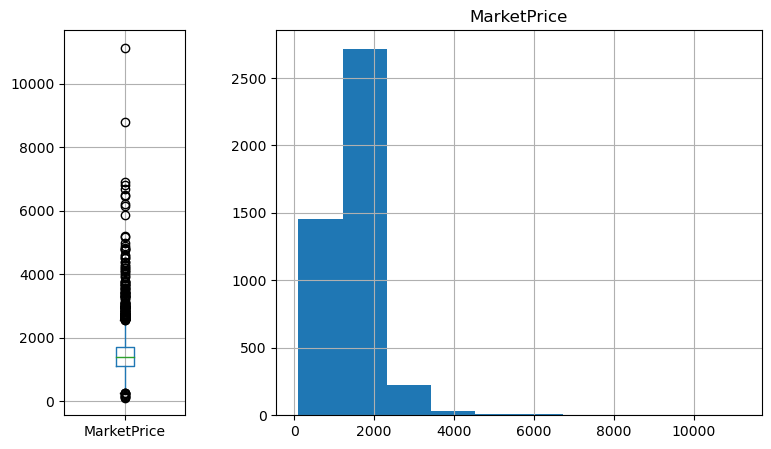

In [72]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
Credit.boxplot(column='MarketPrice',ax=axes[0]);
Credit.hist(column='MarketPrice', ax=axes[1]);

### IQR 

One easy criteria to decide which values are outliers is to use the distance between quartiles. Specifically, you define the outliers as: 
* The values smaller than Q1 - 1.5*IQR
* The values bigger than Q3 + 1.5*IQR

This is the criteria used in the boxplots to marc the outliers. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Boxplot_vs_PDF.svg/1024px-Boxplot_vs_PDF.svg.png" alt="nice_image_from_wikipedia" width="450"/>

If we used this criteria to remove the outliers of our variable we would get the next distribution.

In [73]:
Q1 = Credit['MarketPrice'].quantile(0.25)
Q3 = Credit['MarketPrice'].quantile(0.75)
IQR = Q3 - Q1

Q1, Q3, IQR

(1116.25, 1691.5, 575.25)

In [74]:
small_outliers = Credit['MarketPrice'] < (Q1 - 1.5 * IQR)
big_outliers = Credit['MarketPrice'] > (Q3 + 1.5 * IQR)

sum(small_outliers), sum(big_outliers)

(9, 164)

In [75]:
Credit['MarketPrice'][small_outliers | big_outliers].head()

2      2985
27     2557
100    3262
125    4786
142    8800
Name: MarketPrice, dtype: int64

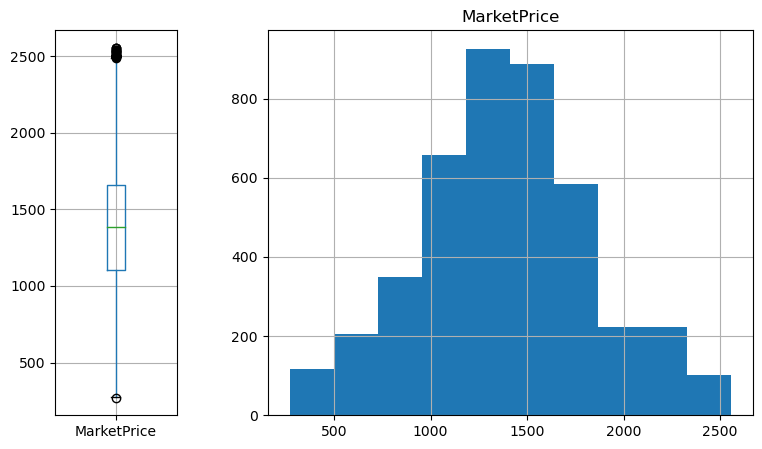

In [76]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
Credit[~(small_outliers | big_outliers)].boxplot(column='MarketPrice',ax=axes[0]);
Credit[~(small_outliers | big_outliers)].hist(column='MarketPrice', ax=axes[1]);

### Model based
Sometimes the classic approaches will not be enough to detect outliers. The data can take many forms, like images, text or just pairs of variables that would not make sense to take independenly for any reason. 

In these cases we will want to use more complex approaches. Here we are going to talk about [Local Outlier Factor](https://dl.acm.org/doi/abs/10.1145/342009.335388), but there are a lot more. 

Local outlier factor uses the local density of a point to decide whether it is an otlier or not. The local density is calculated by using its k nearest neighbors. 

<div class="alert alert-block alert-warning">
If you use a model-based approach you will need to tune its hyperparameters. 
</div>

In [77]:
local_outlier_factor = LocalOutlierFactor(n_neighbors=20)
result = local_outlier_factor.fit_predict(Credit['MarketPrice'].values.reshape(-1, 1))

outliers = result == -1 
no_outliers = result == 1

In [78]:
Counter(result)

Counter({-1: 502, 1: 3944})

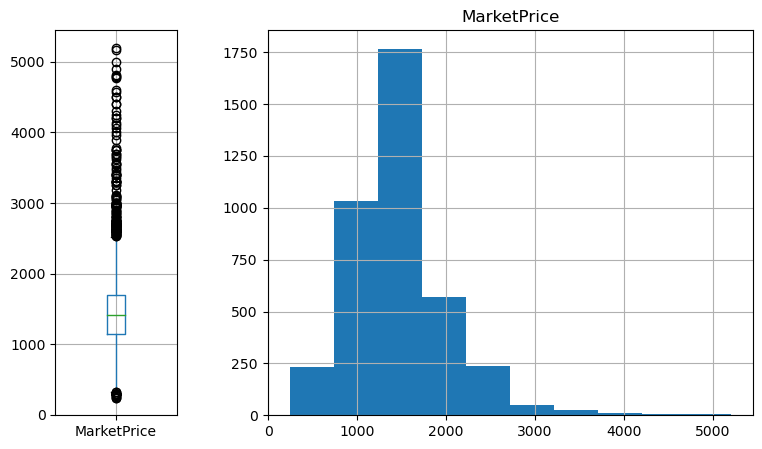

In [79]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
Credit[no_outliers].boxplot(column='MarketPrice',ax=axes[0]);
Credit[no_outliers].hist(column='MarketPrice', ax=axes[1]);

***
## SECTION 5: TREATMENT OF MIXED DATA TYPES


 In this case we have decided to keep the original type and leave the decision for later, depending on the specific analysis

 we explicitly declare categorical variables as such 

In [80]:
Credit.dtypes

Assessment            int64
YearsInJob            int64
Housing               int64
Deadline              int64
Age                   int64
MaritalStatus         int64
Records               int64
TypeOfJob             int64
Expenses              int64
Income              float64
Capital             float64
ChargesOnCapital    float64
AmountRequested       int64
MarketPrice           int64
dtype: object

In [81]:
# There is a categorical datatype in pandas, but for most things this will do
Credit.Assessment = Credit.Assessment.astype('object')
Credit.Housing = Credit.Housing.astype('object')
Credit.MaritalStatus = Credit.MaritalStatus.astype('object')
Credit.Records = Credit.Records.astype('object')
Credit.TypeOfJob = Credit.TypeOfJob.astype('object')

Credit.Assessment.unique()
Credit.Housing .unique()
Credit.MaritalStatus.unique()
Credit.Records.unique()
Credit.TypeOfJob.unique()


array([1, 2], dtype=object)

array([1, 2, 5, 3, 6, 4], dtype=object)

array([2, 3, 1, 4, 5], dtype=object)

array([1, 2], dtype=object)

array([3, 1, 2, 4], dtype=object)

not very nice, right? let's recode

In [82]:
Credit.Assessment.replace([1, 2], 
                          ["positive","negative"], 
                          inplace=True)
Credit.Housing.replace([1,2,3,4,5,6], 
                       ["rent","owner","private","ignore","parents","other"], 
                       inplace=True)
Credit.MaritalStatus.replace([1,2,3,4,5], 
                             ["single","married","widower","split","divorced"], 
                             inplace=True)
Credit.Records.replace([1, 2], 
                       ["no","yes"], inplace=True)
Credit.TypeOfJob.replace([1,2,3,4], 
                         ["indefinite","temporal","self-employed","other"], 
                         inplace=True)


<div class="alert alert-block alert-warning">
If you want to treat a categorical variable as numerical you should never replace the categories by numbers. 
If you do so you are adding an order relationship that did not exist previously in the data, adding noise to your analysis. 
</div>

***
## SECTION 6: DERIVATION OF NEW VARIABLES: FEATURE EXTRACTION

 We decide whether it can be sensible to derive new variables; we extract two new continuous and one new categorical variable (for the sake of illustration):

 Financing ratio (continuous)


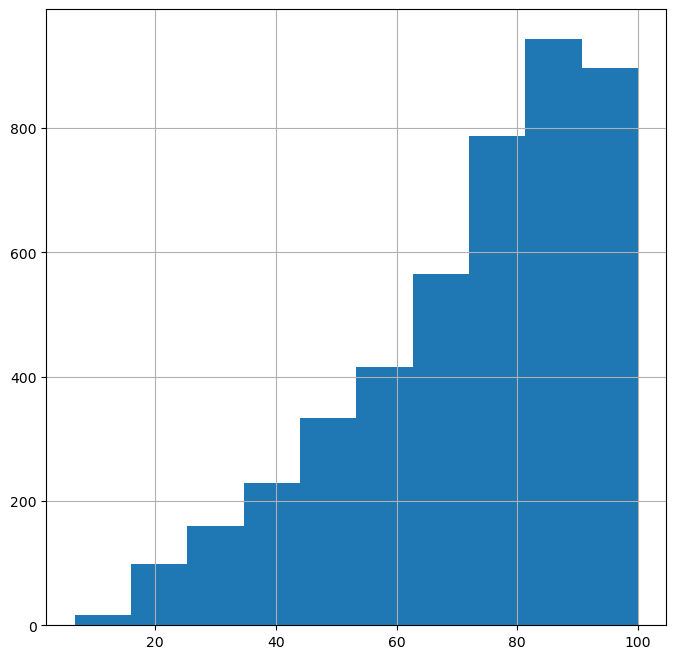

In [83]:
Credit['FinancingRatio'] = 100*Credit.AmountRequested/Credit.MarketPrice
Credit.FinancingRatio.hist(figsize=(8,8));

 Saving capacity (continuous)

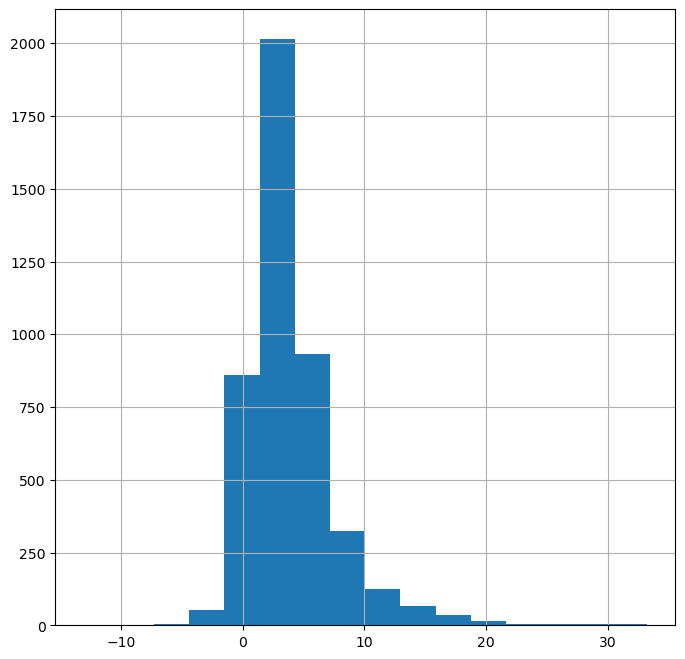

In [84]:
Credit['SavingCapacity'] = (Credit.Income- Credit.Expenses-(Credit.ChargesOnCapital/100))\
                            /(Credit.AmountRequested/Credit.Deadline)
Credit.SavingCapacity.hist(bins=16,figsize=(8,8));

 Amount Requested greater than the median by people younger than 1.25 times the mean (categorical):

In [85]:
Credit['Dubious'] = ['No']*Credit.shape[0]
Credit.Dubious[(Credit.AmountRequested > Credit.AmountRequested.median(skipna=True)) &
               (Credit.Age < 1.25*Credit.Age.mean(skipna=True))] = "Yes"
pd.crosstab(Credit.Dubious, Credit.Assessment)

/tmp/ipykernel_32337/2431663427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Credit.Dubious[(Credit.AmountRequested > Credit.AmountRequested.median(skipna=True)) &


Assessment,negative,positive
Dubious,,
No,668,2200
Yes,581,997


***
## SECTION 7: WHAT WE HAVE DONE SO FAR


 Create a new dataframe that gathers everything and inspect it again

In [86]:
Credit_new =Credit.copy()
                   
Credit_new.describe(include='all')
Credit_new.shape

,Assessment,YearsInJob,Housing,Deadline,Age,MaritalStatus,Records,TypeOfJob,Expenses,Income,Capital,ChargesOnCapital,AmountRequested,MarketPrice,FinancingRatio,SavingCapacity,Dubious
count,4446,4446.000,4446,4446.000,4446.000,4446,4446,4446,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446
unique,2,NaN,6,NaN,NaN,5,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,positive,NaN,owner,NaN,NaN,married,no,indefinite,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
freq,3197,NaN,2106,NaN,NaN,3238,3677,2803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2868
mean,NaN,7.991,NaN,46.453,37.084,NaN,NaN,NaN,55.601,141.689,5383.702,343.312,1038.763,1462.480,72.616,3.911,NaN
std,NaN,8.176,NaN,14.648,10.986,NaN,NaN,NaN,19.521,80.082,11527.920,1245.731,474.748,628.555,20.391,3.738,NaN
min,NaN,0.000,NaN,6.000,18.000,NaN,NaN,NaN,35.000,6.000,0.000,0.000,100.000,105.000,6.702,-13.104,NaN
25%,NaN,2.000,NaN,36.000,28.000,NaN,NaN,NaN,35.000,90.000,0.000,0.000,700.000,1116.250,60.030,1.680,NaN
50%,NaN,5.000,NaN,48.000,36.000,NaN,NaN,NaN,51.000,125.000,3000.000,0.000,1000.000,1400.000,77.097,3.142,NaN
75%,NaN,12.000,NaN,60.000,45.000,NaN,NaN,NaN,72.000,171.000,6000.000,0.000,1300.000,1691.500,88.460,5.232,NaN


(4446, 17)

***
## SECTION 8: GAUSSIANITY AND TRANSFORMATIONS


 Perform a graphical summary of some of the variables (both categorical and continuous), using the boxplot() and hist() procedures

 For continuous data:
 histograms and boxplots

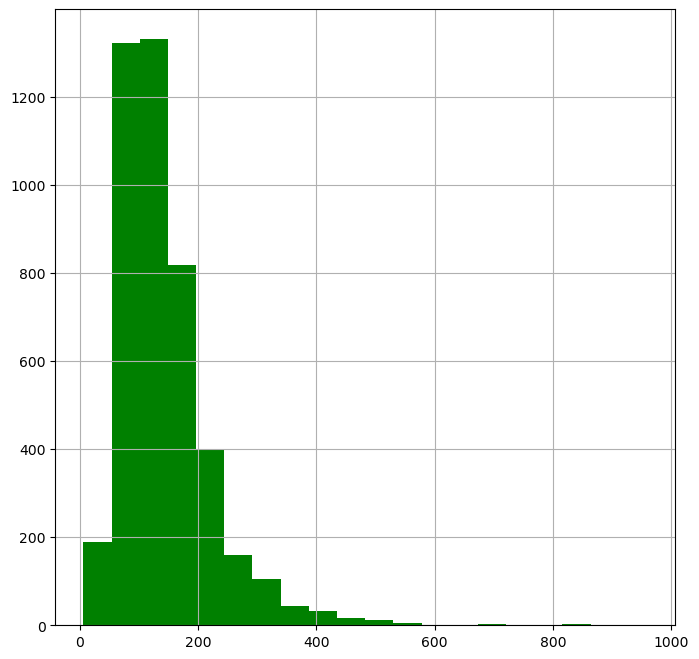

In [87]:
Credit_new.Income.hist(bins=20,figsize=(8,8), color='green');

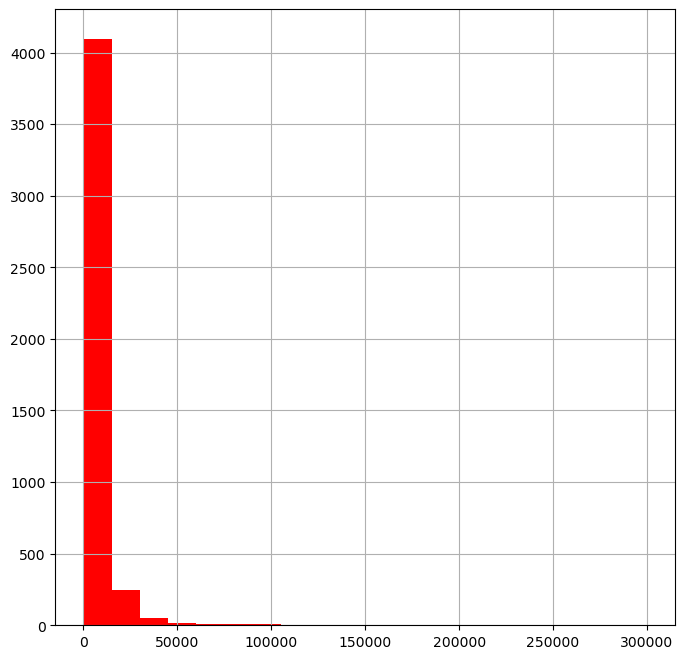

In [88]:
Credit_new.Capital.hist(bins=20,figsize=(8,8), color='red');

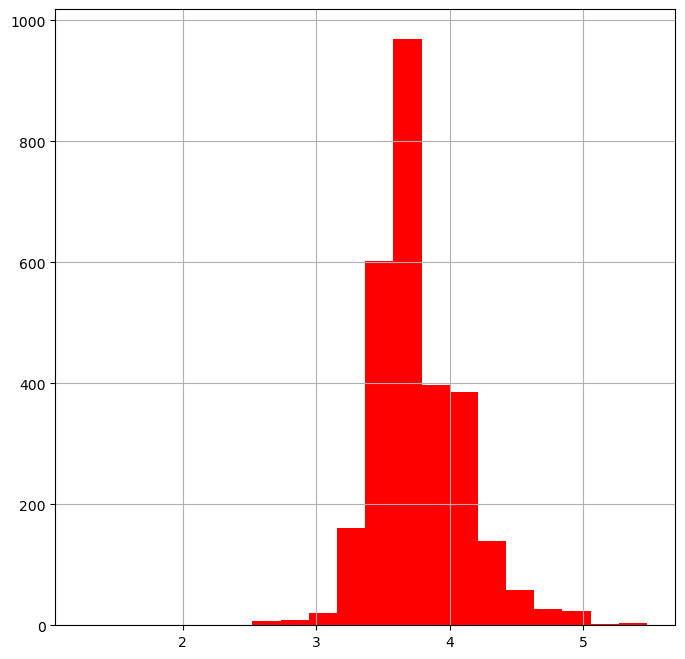

In [89]:
pd.options.mode.use_inf_as_na = True
Credit_new.Capital.apply(np.log10).hist(bins=20,figsize=(8,8), color='red');

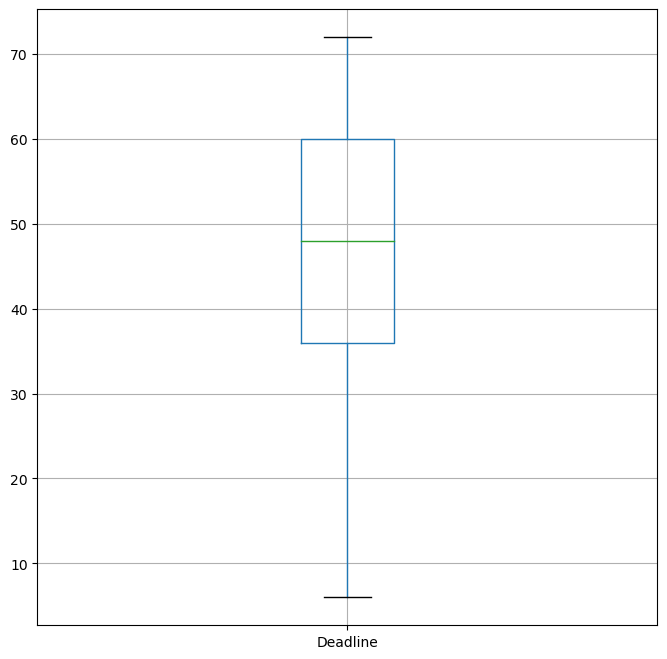

In [90]:
Credit_new.boxplot(column='Deadline',figsize=(8,8));

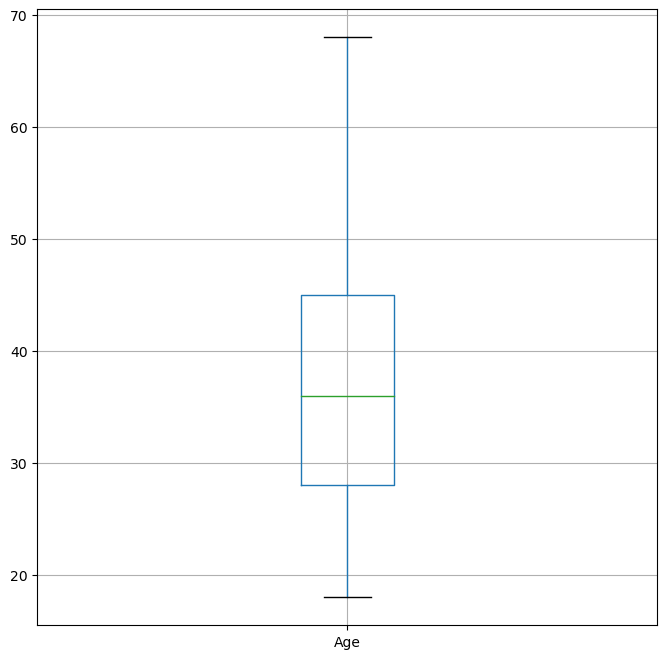

In [91]:
Credit_new.boxplot(column='Age',figsize=(8,8));

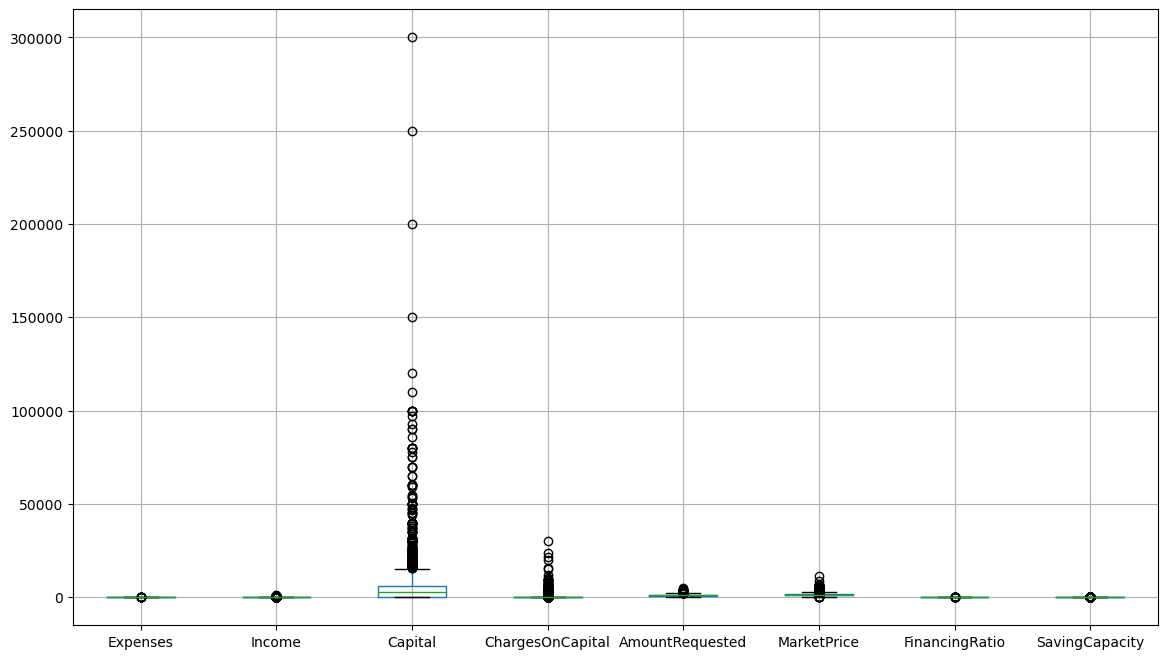

In [92]:
Credit_new.loc[:,"Expenses":"SavingCapacity"].boxplot(figsize=(14,8));

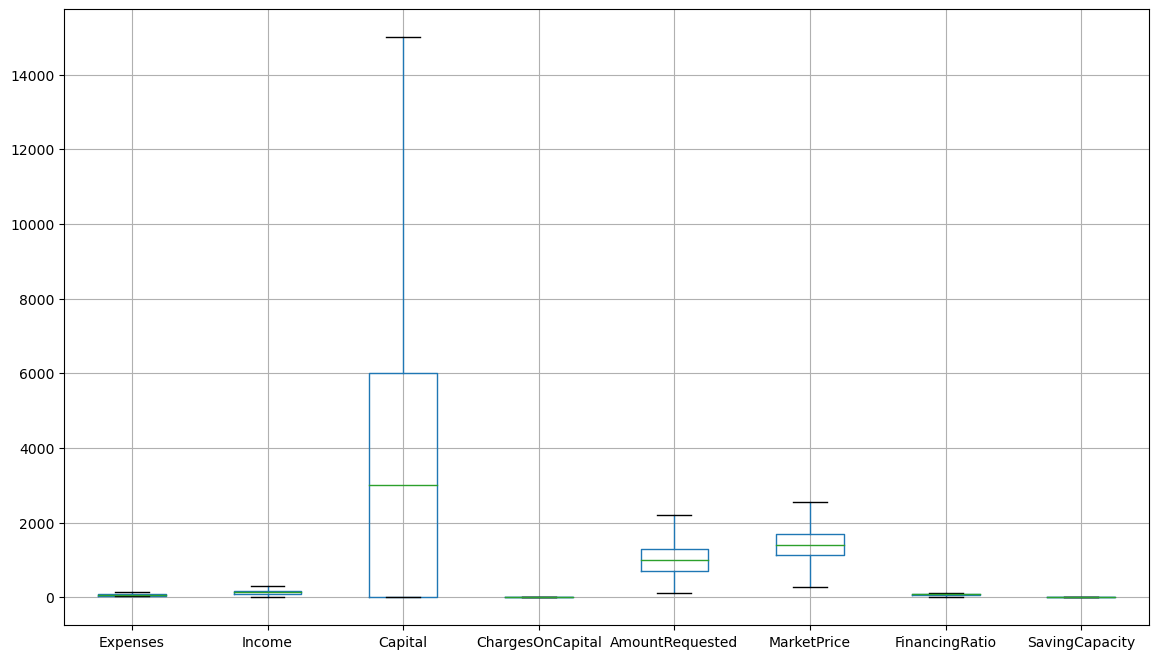

In [93]:
Credit_new.loc[:,"Expenses":"SavingCapacity"].boxplot(figsize=(14,8),showfliers=False); # much better, but would be nicer one by one

 the previous plots suggest to take logs on some variables: Capital and ChargesOnCapital (we'll do it later)

 For categorical data:
 Frequency tables, Contingency tables, Bar charts, Pie charts

 should we treat Age as categorical? probably not

### Transform numerical variables into categorical

In [94]:
Credit_new.Age.unique()

array([30, 58, 46, 24, 26, 36, 44, 27, 32, 41, 34, 29, 37, 21, 68, 52, 31,
       25, 22, 45, 51, 54, 43, 23, 39, 35, 62, 56, 64, 42, 61, 49, 47, 28,
       63, 55, 40, 53, 38, 57, 33, 66, 50, 48, 59, 60, 19, 65, 20, 18])

In [95]:
Credit_new.Age.min()
Credit_new.Age.max()

18

68

In [96]:
bins = pd.IntervalIndex.from_tuples([(0, 1), (2, 3), (4, 5)])
bins

IntervalIndex([(0, 1], (2, 3], (4, 5]], dtype='interval[int64, right]')

In [97]:
pd.interval_range(start=30, end=90,freq=10)

IntervalIndex([(30, 40], (40, 50], (50, 60], (60, 70], (70, 80], (80, 90]], dtype='interval[int64, right]')

In [98]:
pd.cut(Credit_new.Age,
       bins=pd.interval_range(start=30, end=90,freq=10))  
# WARNING! we are generating NAs               

0                NaN
1       (50.0, 60.0]
2       (40.0, 50.0]
3                NaN
4                NaN
            ...     
4450    (30.0, 40.0]
4451    (40.0, 50.0]
4452    (30.0, 40.0]
4453             NaN
4454    (30.0, 40.0]
Name: Age, Length: 4446, dtype: category
Categories (6, interval[int64, right]): [(30, 40] < (40, 50] < (50, 60] < (60, 70] < (70, 80] < (80, 90]]

In [99]:
Age_cut = pd.cut(Credit_new.Age,
                 bins=pd.interval_range(start=15, end=75,freq=10)) ;

In [100]:
Credit_new['Age_cat'] = Age_cut.astype('str')

In [101]:
Credit_new.Age_cat.value_counts().sort_index()

(15, 25]     699
(25, 35]    1509
(35, 45]    1172
(45, 55]     773
(55, 65]     282
(65, 75]      11
Name: Age_cat, dtype: int64

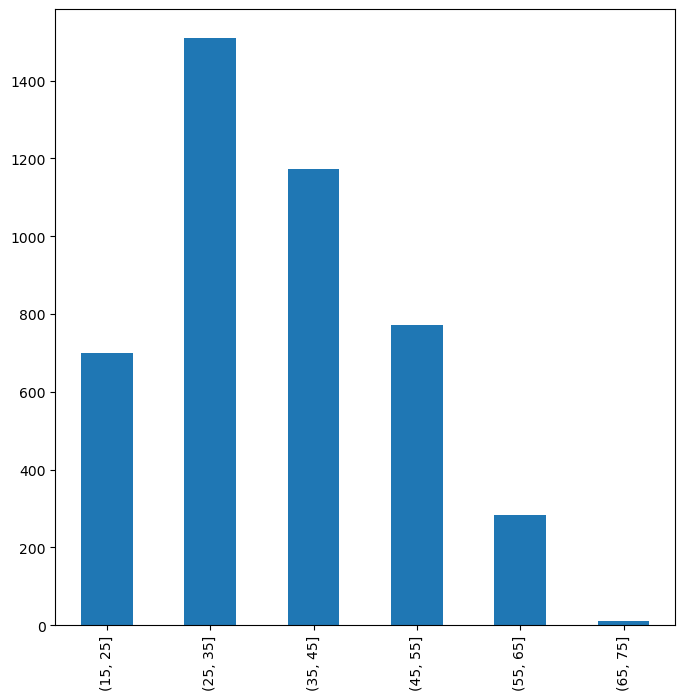

In [102]:
Credit_new.Age_cat.value_counts().sort_index().plot.bar(figsize=(8,8));

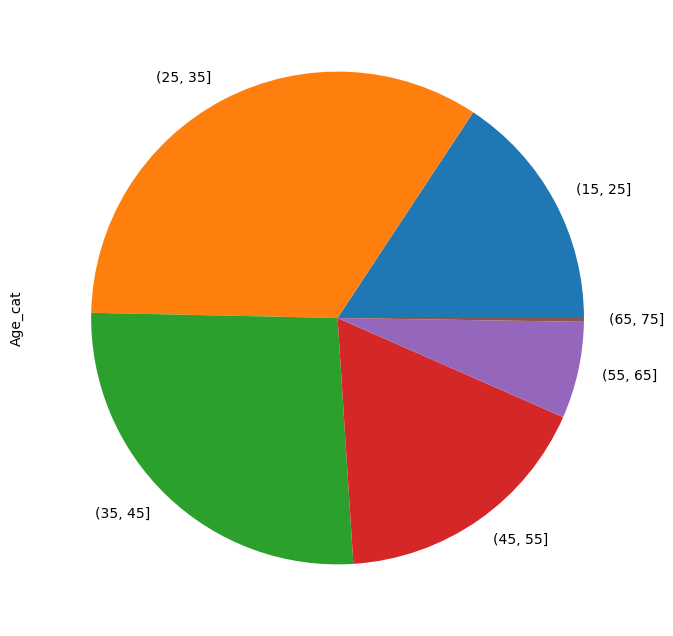

In [103]:
Credit_new.Age_cat.value_counts().sort_index().plot.pie(figsize=(8,8));

 incidentally, this is how we could generate another new variable based on Age:

In [104]:
Credit_new['Age2_cat'] = Credit_new.Age.apply(lambda x : 
                                              'under55' if x < 55 else 'over55')

In [105]:
TypeOfJob_Age= pd.crosstab(Credit_new.TypeOfJob, Credit_new.Age_cat)
TypeOfJob_Age

Age_cat,"(15, 25]","(25, 35]","(35, 45]","(45, 55]","(55, 65]","(65, 75]"
TypeOfJob,,,,,,
indefinite,408,1054,742,463,132,4
other,17,28,30,30,61,5
self-employed,91,272,319,250,87,2
temporal,183,155,81,30,2,0


<AxesSubplot:xlabel='Age_cat', ylabel='TypeOfJob'>

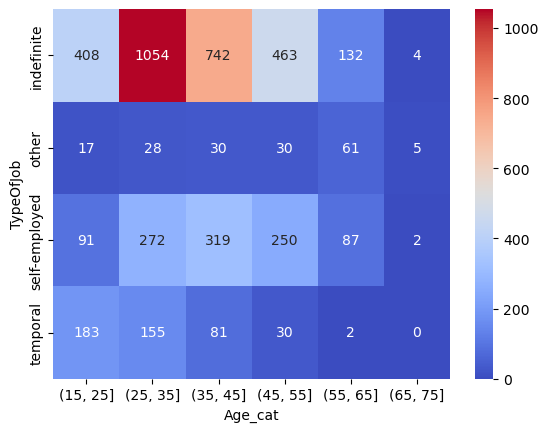

In [106]:
sn.heatmap(TypeOfJob_Age, annot=True, fmt="d", cmap='coolwarm')

In [107]:
TypeOfJob_Age.sum(axis=0) # row sums
TypeOfJob_Age.sum(axis=1) # column sums

Age_cat
(15, 25]     699
(25, 35]    1509
(35, 45]    1172
(45, 55]     773
(55, 65]     282
(65, 75]      11
dtype: int64

TypeOfJob
indefinite       2803
other             171
self-employed    1021
temporal          451
dtype: int64

In [108]:
pd.crosstab(Credit_new.TypeOfJob, 
            Credit_new.Age_cat,
            normalize=True,
            margins=True) # relative frequencies

Age_cat,"(15, 25]","(25, 35]","(35, 45]","(45, 55]","(55, 65]","(65, 75]",All
TypeOfJob,,,,,,,
indefinite,0.092,0.237,0.167,0.104,2.969e-02,8.997e-04,0.630
other,0.004,0.006,0.007,0.007,1.372e-02,1.125e-03,0.038
self-employed,0.020,0.061,0.072,0.056,1.957e-02,4.498e-04,0.230
temporal,0.041,0.035,0.018,0.007,4.498e-04,0.000e+00,0.101
All,0.157,0.339,0.264,0.174,6.343e-02,2.474e-03,1.000


In [109]:
pd.crosstab(Credit_new.TypeOfJob, 
            Credit_new.Age_cat,
            normalize=True,margins=True).round(decimals=3)
            # idem, rounded to 3 digits

Age_cat,"(15, 25]","(25, 35]","(35, 45]","(45, 55]","(55, 65]","(65, 75]",All
TypeOfJob,,,,,,,
indefinite,0.092,0.237,0.167,0.104,0.030,0.001,0.630
other,0.004,0.006,0.007,0.007,0.014,0.001,0.038
self-employed,0.020,0.061,0.072,0.056,0.020,0.000,0.230
temporal,0.041,0.035,0.018,0.007,0.000,0.000,0.101
All,0.157,0.339,0.264,0.174,0.063,0.002,1.000


In [110]:
(pd.crosstab(Credit_new.TypeOfJob,
             Credit_new.Age_cat,
             normalize=True,
             margins=True)*100).round(decimals=3) 
             # total percentages

Age_cat,"(15, 25]","(25, 35]","(35, 45]","(45, 55]","(55, 65]","(65, 75]",All
TypeOfJob,,,,,,,
indefinite,9.177,23.707,16.689,10.414,2.969,0.090,63.045
other,0.382,0.630,0.675,0.675,1.372,0.112,3.846
self-employed,2.047,6.118,7.175,5.623,1.957,0.045,22.964
temporal,4.116,3.486,1.822,0.675,0.045,0.000,10.144
All,15.722,33.941,26.361,17.386,6.343,0.247,100.000


In [111]:
pd.crosstab(Credit_new.TypeOfJob,
            Credit_new.Age_cat,
            normalize="index").round(decimals=3) 
            # table of relative frequencies (column-wise)
pd.crosstab(Credit_new.TypeOfJob, 
            Credit_new.Age_cat,
            normalize="columns").round(decimals=3) 
            # table of relative frequencies (row-wise)

Age_cat,"(15, 25]","(25, 35]","(35, 45]","(45, 55]","(55, 65]","(65, 75]"
TypeOfJob,,,,,,
indefinite,0.146,0.376,0.265,0.165,0.047,0.001
other,0.099,0.164,0.175,0.175,0.357,0.029
self-employed,0.089,0.266,0.312,0.245,0.085,0.002
temporal,0.406,0.344,0.180,0.067,0.004,0.000


Age_cat,"(15, 25]","(25, 35]","(35, 45]","(45, 55]","(55, 65]","(65, 75]"
TypeOfJob,,,,,,
indefinite,0.584,0.698,0.633,0.599,0.468,0.364
other,0.024,0.019,0.026,0.039,0.216,0.455
self-employed,0.130,0.180,0.272,0.323,0.309,0.182
temporal,0.262,0.103,0.069,0.039,0.007,0.000


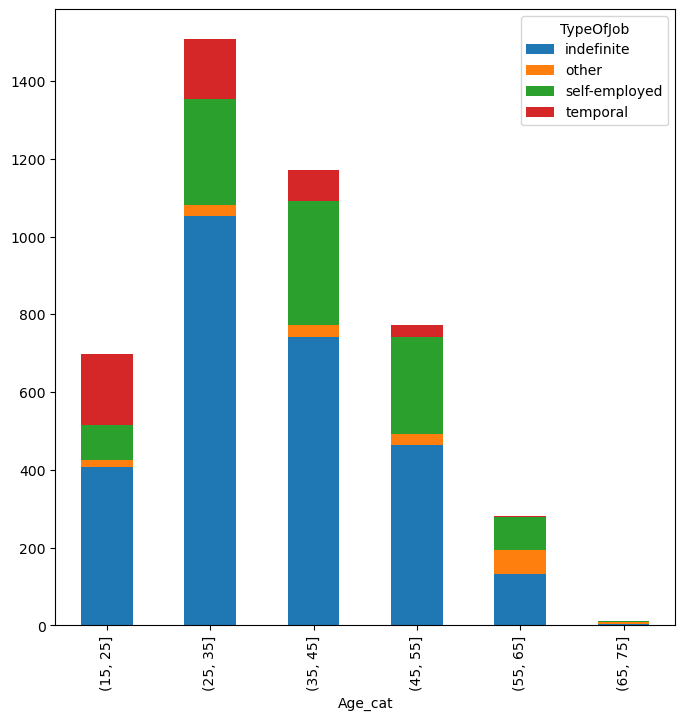

In [112]:
# basic stacked bar chart
TypeOfJob_Age.T.plot.bar(stacked=True, figsize=(8,8));  

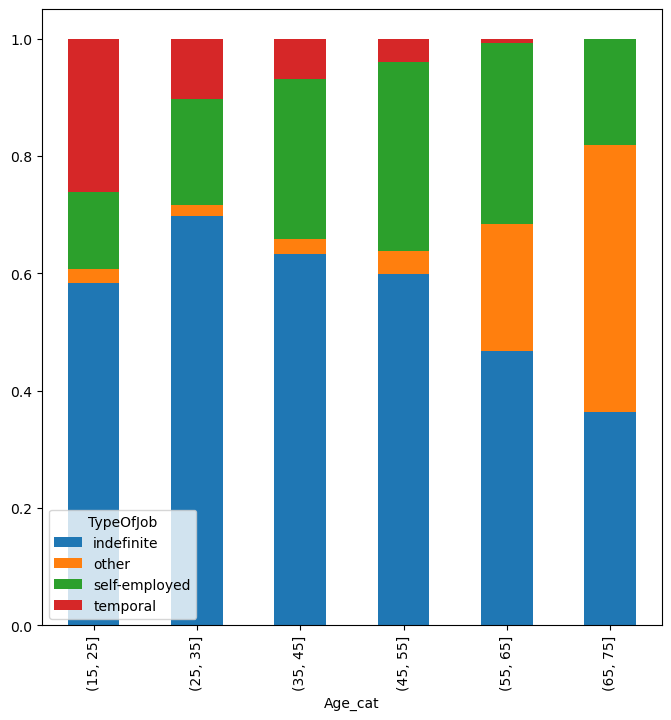

In [113]:
pd.crosstab(Credit_new.TypeOfJob, 
            Credit_new.Age_cat,
            normalize="columns").T.plot.bar(stacked=True, figsize=(8,8));

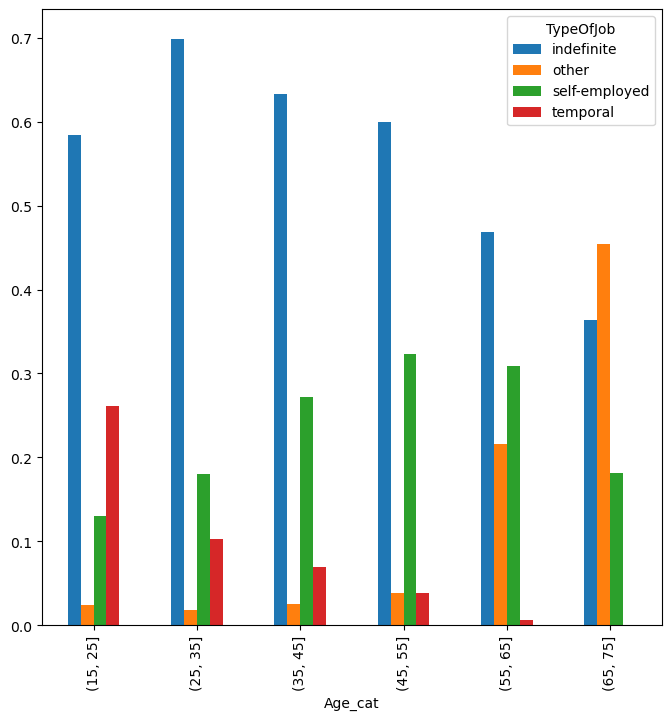

In [114]:
# grouped bar chart
pd.crosstab(Credit_new.TypeOfJob, 
            Credit_new.Age_cat,
            normalize="columns").T.plot.bar(figsize=(8,8));


###  One hot encoding (dummy encoding)

Sometimes you will want to treat some (of all) your categorical variables as numerical. This can happen if, for example you want to train a model that does not accept categorical variables. 
There are different methods to codify the categories. One of the most simple and comonly used is one hot encoding.  

In [115]:
Credit['Records'].head()

0     no
1     no
2    yes
3     no
4     no
Name: Records, dtype: object

In [116]:
pd.get_dummies(Credit['Records'], prefix='Records').head()

,Records_no,Records_yes
0,1,0
1,1,0
2,0,1
3,1,0
4,1,0


### Compare variables 

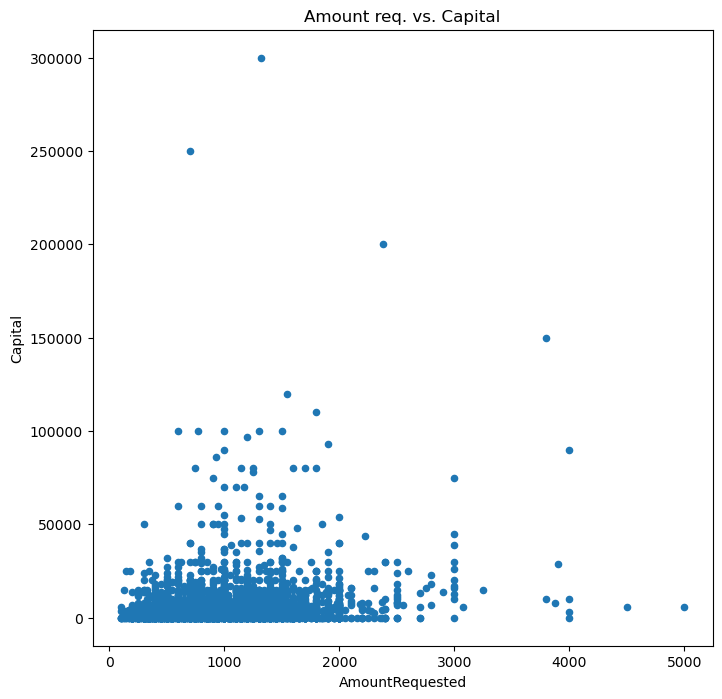

In [117]:
Credit_new.plot.scatter(y='Capital',
                        x='AmountRequested', 
                        figsize=(8,8),
                        title='Amount req. vs. Capital');

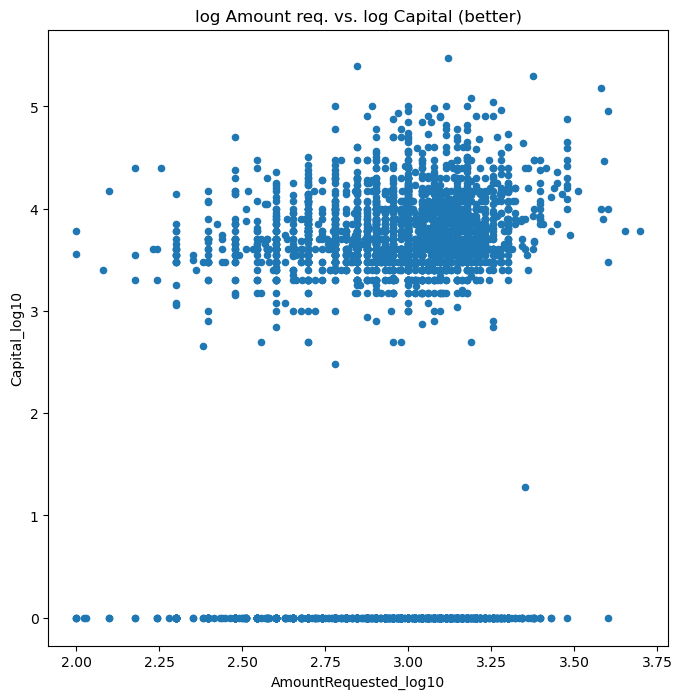

In [118]:
Credit_new['Capital_log10'] = (Credit_new.Capital+1).apply(np.log10)
Credit_new['AmountRequested_log10'] = (Credit_new.AmountRequested).apply(np.log10)
Credit_new.plot.scatter(y='Capital_log10',
                        x='AmountRequested_log10', 
                        figsize=(8,8),
                        title='log Amount req. vs. log Capital (better)');

 adding a center (dashed) and a regression line (red)

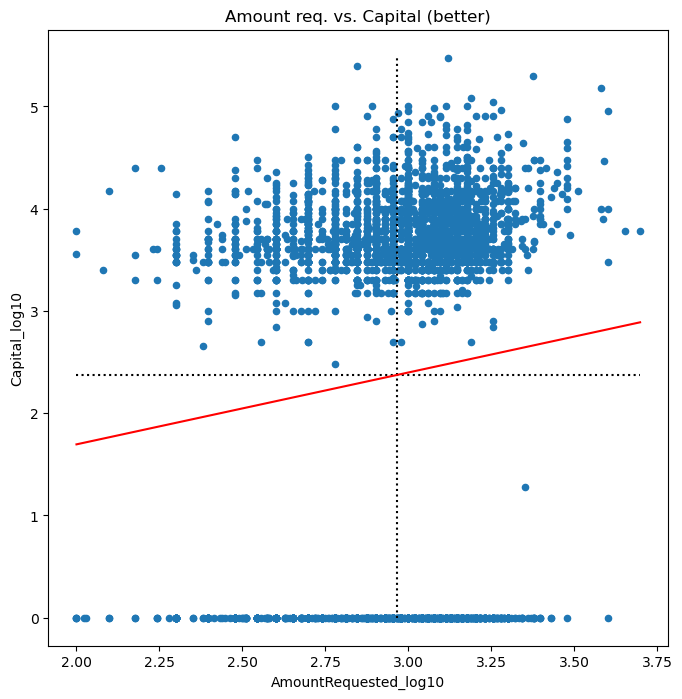

In [119]:

model = GLM.from_formula('Capital_log10 ~ AmountRequested_log10', Credit_new)
result = model.fit()

Credit_new.plot.scatter(y='Capital_log10',
                        x='AmountRequested_log10', 
                        figsize=(8,8))
plt.title('Amount req. vs. Capital (better)');
plt.plot([Credit_new.AmountRequested_log10.mean()]*2,
         [Credit_new.Capital_log10.min(),
          Credit_new.Capital_log10.max()],
         'k:');
plt.plot([Credit_new.AmountRequested_log10.min(),
          Credit_new.AmountRequested_log10.max()],
         [Credit_new.Capital_log10.mean()]*2,
         'k:');
plt.plot(np.linspace(Credit_new.AmountRequested_log10.min(), 
                     Credit_new.AmountRequested_log10.max(),
                     num=30),
         result.params.Intercept+
         result.params.AmountRequested_log10*
         np.linspace(Credit_new.AmountRequested_log10.min(),                                                             
                     Credit_new.AmountRequested_log10.max(),num=30),'r');


 (note that log10(x+1)=0 for x=0, so our transformation keeps the zeros)
     
 On the other hand, these same zeros spoil the regression: perhaps it would be more sensible to do the regression without them

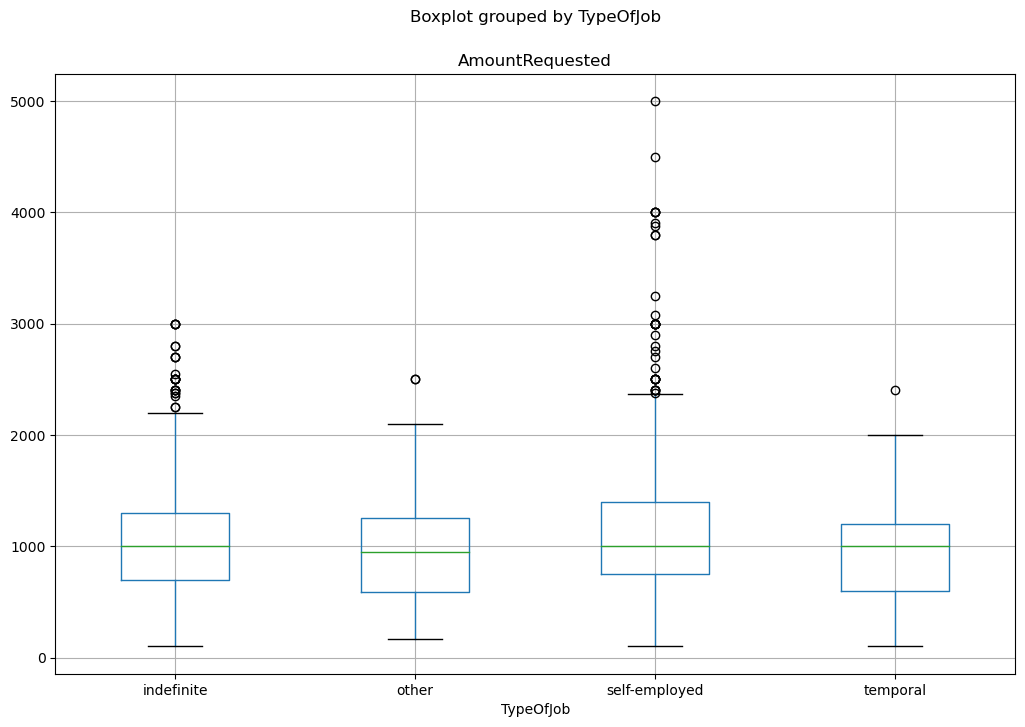

In [120]:
Credit_new.boxplot(column='AmountRequested',
                   by='TypeOfJob',
                   figsize=(12,8));

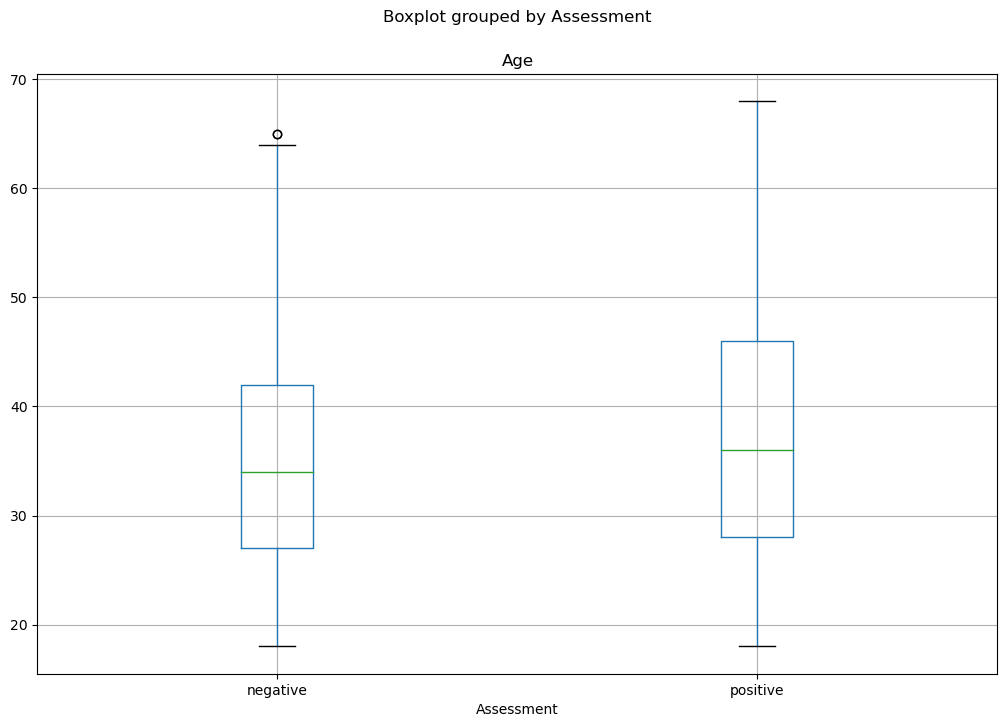

In [121]:
Credit_new.boxplot(column='Age',
                   by='Assessment',
                   figsize=(12,8));

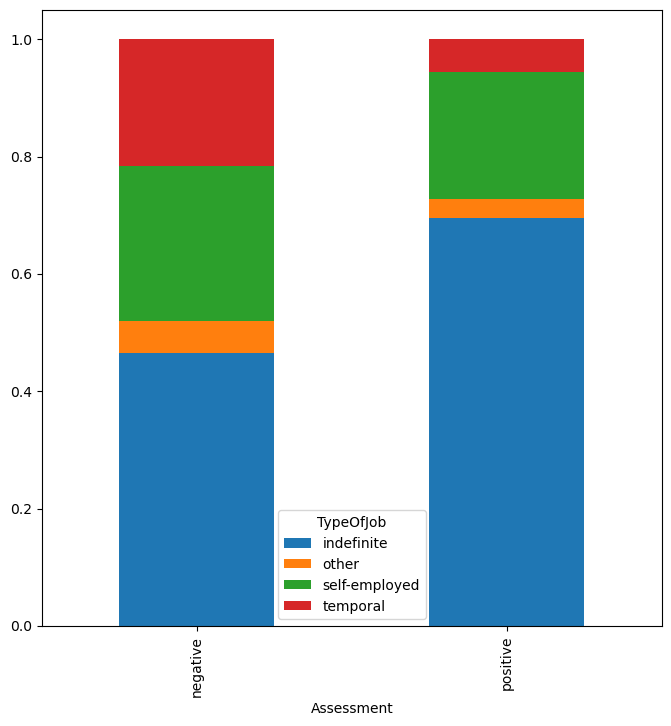

In [122]:
pd.crosstab(Credit_new.TypeOfJob, 
            Credit_new.Assessment,
            normalize="columns").T.plot.bar(stacked=True, 
                                            figsize=(8,8));

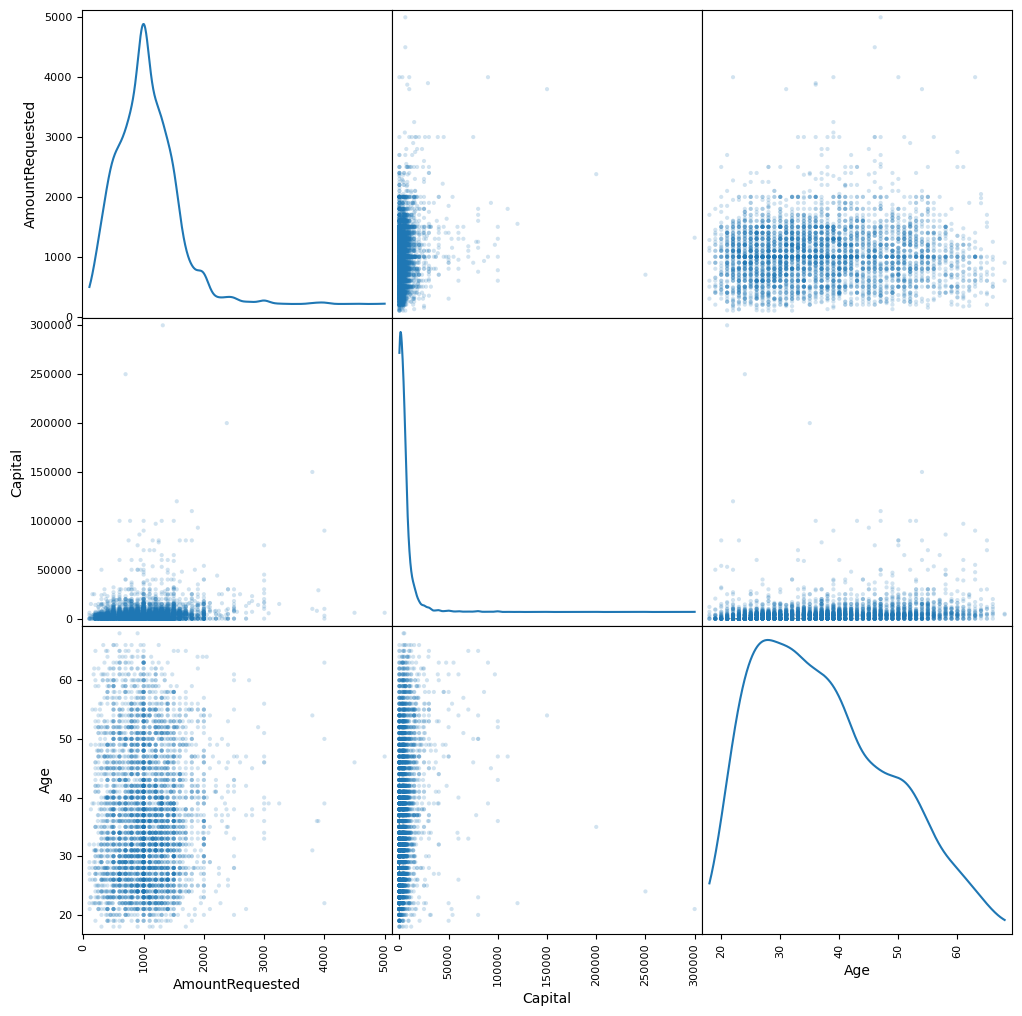

In [123]:
scatter_matrix(Credit_new.loc[:,['AmountRequested','Capital','Age']], 
               alpha=0.2, figsize=(12, 12), 
               diagonal='kde', marker='.');

### Gaussianity

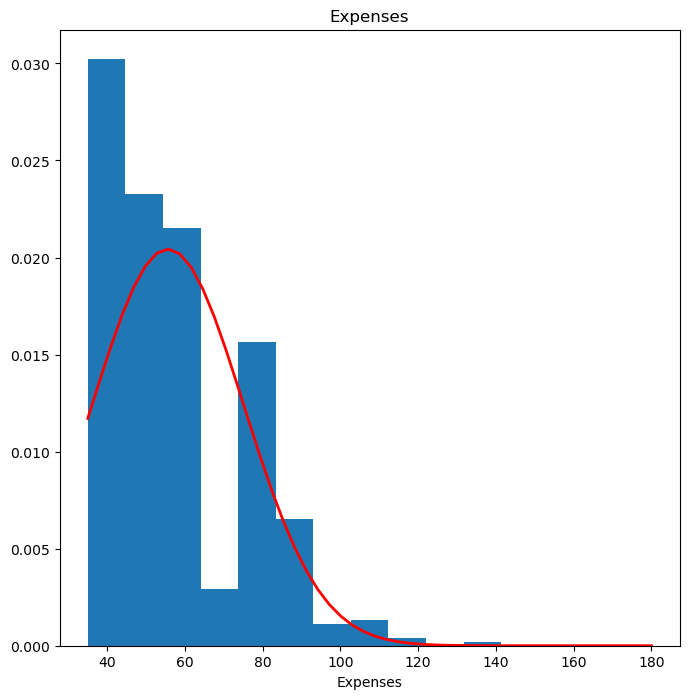

In [124]:
sigma=  Credit_new.Expenses.std()
mu=  Credit_new.Expenses.mean()
fig, ax = plt.subplots(figsize=(8,8))
count, bins, ignored = plt.hist(Credit_new.Expenses, 15, density=True)
dbins = np.linspace(bins[0], bins[-1])
plt.title("Expenses")
ax.set_xlabel("Expenses")
plt.plot(dbins, 1/(sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (dbins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r');

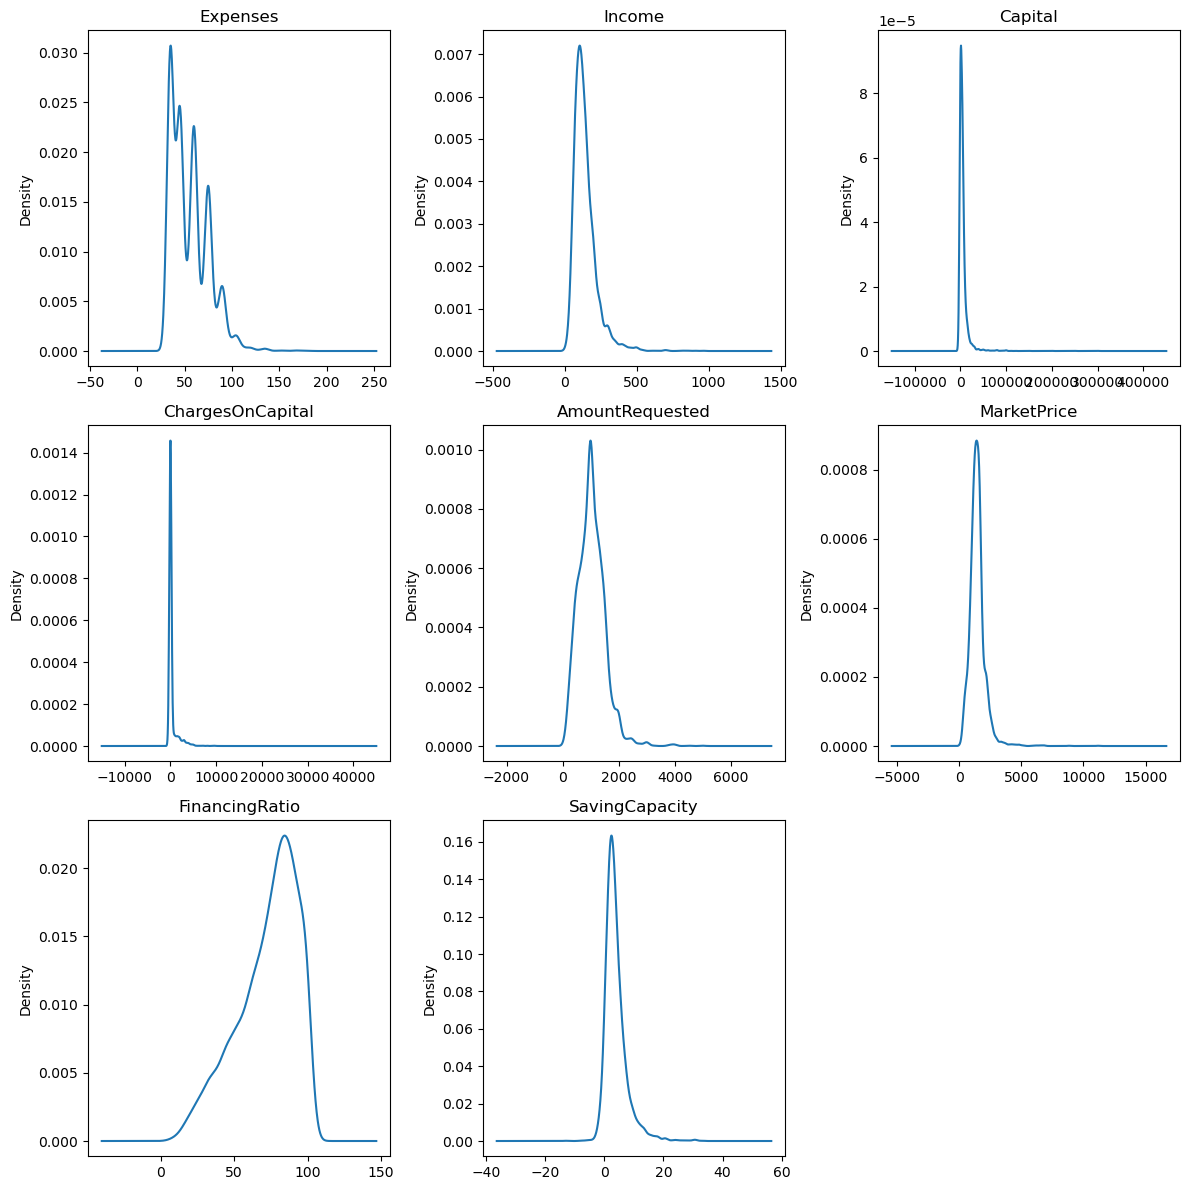

In [125]:
fig = plt.figure(figsize=(12,12))
for i in range(8):
    ax = fig.add_subplot(3, 3, i+1)
    Credit_new[Credit.columns[i+8]].plot.kde()
    plt.title(Credit.columns[i+8])
fig.tight_layout();

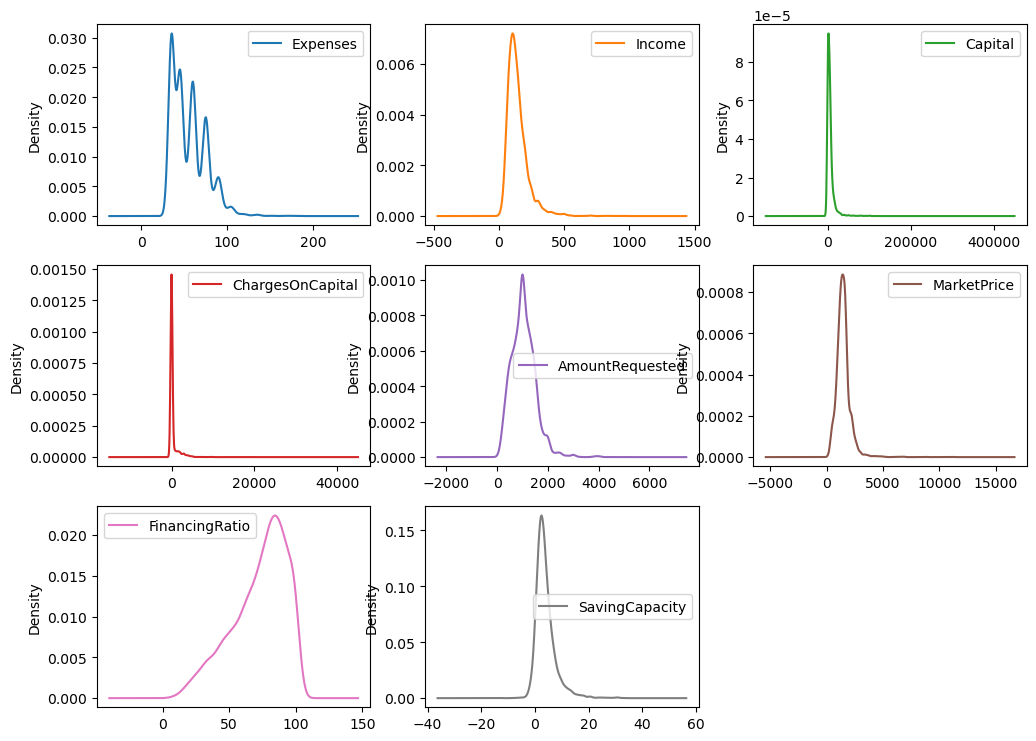

In [126]:
Credit_new.loc[:,'Expenses':'SavingCapacity'].plot.kde(subplots=True,
                                                       layout=(4,3),
                                                       sharex=False, 
                                                       figsize=(12,12));

 do any of the continuous variables "look" Gaussian? 
 features to look for in comparing to a Gaussian: outliers, asymmetries, long tails

## SECTION:9 NORMALIZATION

If you try to train a model with varaibles of ranges too far away it will be a disaster most of the times. Becasue the model might only "see" the bigger variable. 

To avoid this issue you usualy normalize or standarize your data. This way you force all your variables to have the same range. 
There are models that are very sensitive to this and might even fail to converge if you don't normalize your data. 

The most comon transformations for normalizing the data are: 
* Standarization: $\frac{X - \mu}{\sigma}$ will trasnform your data so it has mean 0 and std 1.
* Min-max scaling: $\frac{X - X_{min}}{X_{max} - X_{min}}$ will send your data to the range [0,1]
* Boxcox transformation: $\frac{X^\lambda - 1}{ \lambda}$ if $\lambda \neq 0$ or $ln(X)$ if $\lambda = 0$ transforms the data to try to fit a normal distribution. 


In [127]:
Credit_new[['Age', 'MarketPrice']].describe()

,Age,MarketPrice
count,4446.000,4446.000
mean,37.084,1462.480
std,10.986,628.555
min,18.000,105.000
25%,28.000,1116.250
50%,36.000,1400.000
75%,45.000,1691.500
max,68.000,11140.000


In [128]:
min_max_scaler =  preprocessing.MinMaxScaler()
Credit_new[['Age_min_max', 'MarketPrice_min_max']] = min_max_scaler.fit_transform(Credit_new[['Age', 'MarketPrice']])
std_scaler = preprocessing.StandardScaler()
Credit_new[['Age_std','MarketPrice_std']]= preprocessing.scale(Credit_new[['Age', 'MarketPrice']])

x, _= boxcox(Credit_new['Age'])
Credit_new['Age_bx'] = x

x, _= boxcox(Credit_new['MarketPrice'])
Credit_new['MarketPrice_bx'] = x

In [129]:
Credit_new[['Age_min_max', 'MarketPrice_min_max','Age_std', 'MarketPrice_std', 'Age_bx','MarketPrice_bx']].describe()

,Age_min_max,MarketPrice_min_max,Age_std,MarketPrice_std,Age_bx,MarketPrice_bx
count,4446.000,4446.000,4.446e+03,4.446e+03,4446.000,4446.000
mean,0.382,0.123,1.594e-16,-8.950e-17,3.657,25.559
std,0.220,0.057,1.000e+00,1.000e+00,0.311,3.500
min,0.000,0.000,-1.737e+00,-2.160e+00,2.947,10.067
25%,0.200,0.092,-8.269e-01,-5.509e-01,3.408,23.780
50%,0.360,0.117,-9.869e-02,-9.941e-02,3.671,25.673
75%,0.540,0.144,7.206e-01,3.644e-01,3.905,27.355
max,1.000,1.000,2.814e+00,1.540e+01,4.341,50.476


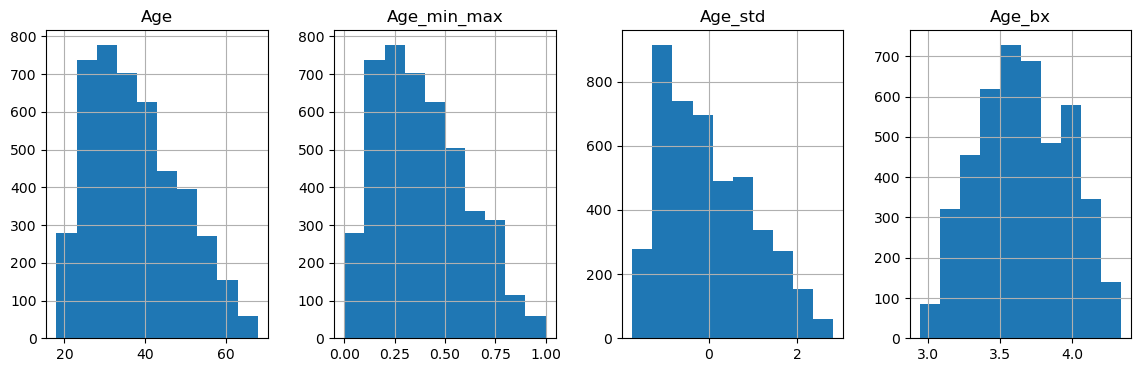

In [130]:
Credit_new[['Age','Age_min_max', 'Age_std', 'Age_bx']].hist(figsize=(14,4), layout=(1,4));

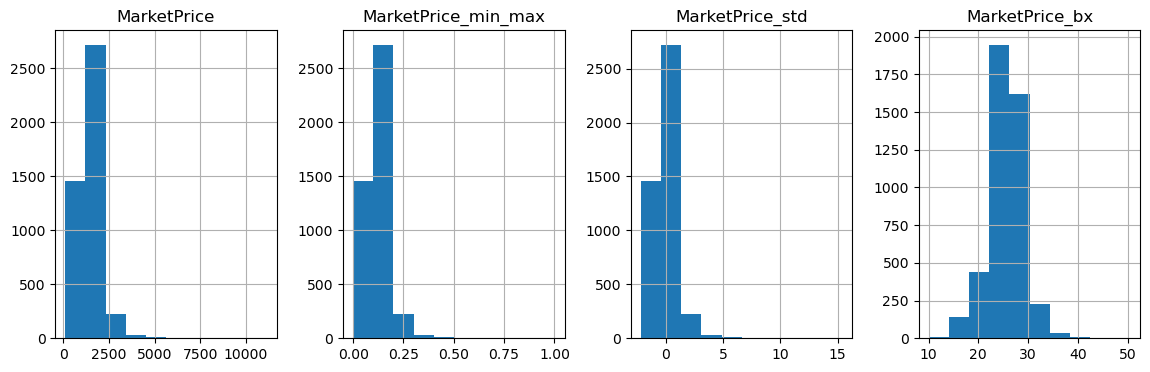

In [131]:
Credit_new[['MarketPrice','MarketPrice_min_max', 'MarketPrice_std', 'MarketPrice_bx']].hist(figsize=(14,4), layout=(1,4));

extra plot boxcox transformation: 

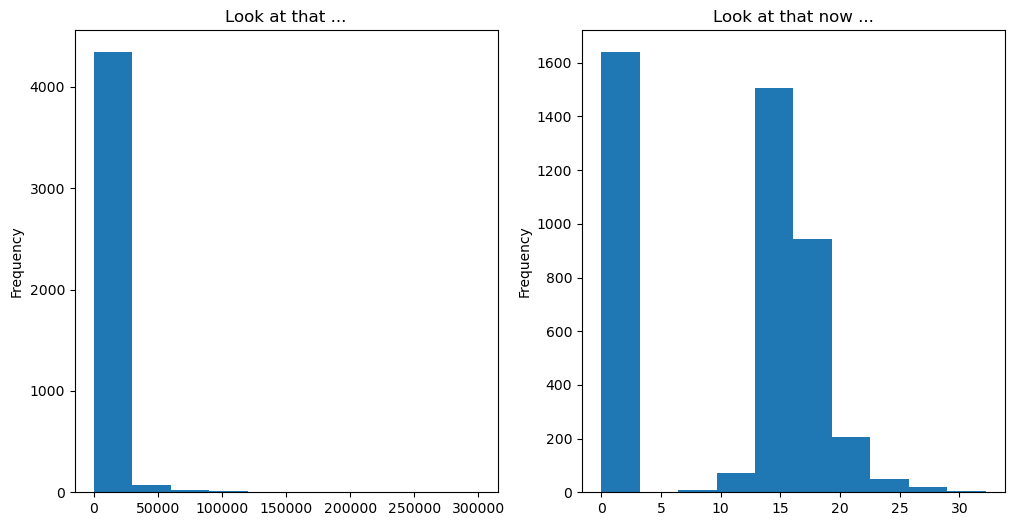

In [132]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1)
Credit_new.Capital.plot.hist(title='Look at that ...')

# the boxcox function transforms the data using 
# the power transformation (x**lambda -1)/ lambda
# the function takes care of finding the optimal lambda
x, _= boxcox(Credit_new.Capital+1)

Credit_new['Capital_BC'] = x
ax = fig.add_subplot(1, 2, 2)
Credit_new.Capital_BC.plot.hist(title='Look at that now ...');

## SECTION 10: ENDING THE PREPROCESSING

  
 Shuffle the data (to avoid possible ordering biases)

In [133]:
np.random.seed(144)
Credit_new = Credit_new.sample(frac=1).reset_index(drop=True)

 
 Save the preprocessed data into a file for future use
<div class="alert alert-block alert-warning">
Pandas allows to save the data in a lot of different formats as you can see [here](http://pandas-docs.github.io/pandas-docs-travis/io.html) among others CSV, pickle, HDF5, JSON, Excel as well as other data storages like SQL databases, Google Big Query, parquet or feather.

The simplest way is to save the data as a csv with `to_csv` or as a pickle file (native python store format) with `to_pickle`, this last one allows also to compress the data.
</div>


In [134]:
Credit_new.to_pickle('Credsco-processed.pkl.bz2',compression='bz2')

In [135]:
Credit_load =pd.read_pickle('Credsco-processed.pkl.bz2',compression='bz2')
Credit_load.head()

,Assessment,YearsInJob,Housing,Deadline,Age,MaritalStatus,Records,TypeOfJob,Expenses,Income,...,Age2_cat,Capital_log10,AmountRequested_log10,Age_min_max,MarketPrice_min_max,Age_std,MarketPrice_std,Age_bx,MarketPrice_bx,Capital_BC
0,negative,5,other,60,33,single,no,indefinite,35,57.0,...,under55,0.000,3.000,0.30,0.119,-0.372,-0.076,3.580,25.766,0.000
1,positive,5,owner,48,43,married,no,self-employed,45,145.0,...,under55,3.699,2.833,0.50,0.113,0.539,-0.179,3.857,25.361,15.660
2,negative,2,parents,36,21,single,no,self-employed,35,221.0,...,under55,0.000,2.699,0.06,0.049,-1.464,-1.293,3.107,19.744,0.000
3,positive,7,owner,36,33,married,no,indefinite,45,208.0,...,under55,3.602,2.699,0.30,0.107,-0.372,-0.278,3.580,24.962,14.989
4,negative,8,rent,60,25,married,yes,indefinite,73,280.0,...,under55,0.000,2.778,0.14,0.114,-1.100,-0.157,3.289,25.449,0.000
